# Predicting Traffic Volume on the I-94 in Minnesota, USA

Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The purpose of this notebook is to predict the traffic flow at a particular point of an interstate highway. The data was recorded hourly on highway I-94 between Minneapolis and St. Paul, Minnesota over a six year period. It contains both numerical and categorical features, with a target variable counting the number of cars passing a point each hour. Descriptions and ranges of the features are given below.

1. holiday (categorical) - national and regional holidays: either None or name of holiday
2. temp (numerical continuous) - average temperature over the course of the hour (Kelvin): 0.00 to 310.07
3. rain_1h (numerical continuous) - rain that fell during the hour (mm): 0.0 to 9831.3
4. snow_1h (numerical continuous) - amount of snow accumulated during the hour (mm): 0.0 to 0.51
5. clouds_all (numerical discrete) - percentage of cloud cover (%): 0 to 100
6. weather_main (categorical) - short description of weather for the hour: eg. 'sunny' or 'rainy'
7. weather_description (categorical) - more detailed description of the weather: 7.9 to 860.6
8. date_time (date/time) - the date and time of day the data was measured: 0.0 to 56.10
9. traffic_volume (numerical discrete) - number of cars passing point of interest (target variable): 0 to 7280


## Comparison of Random Parameter Search

The model selection notebook runs random parameter searches and saves the results of all parameter combinations. Since there may be several good (nearly equal) models identified by the parameter search, it makes sense to look at the parameter ranges associated with the well performing models, to ensure a value is chosen that corresponds to a robust range of model performance

The plots below show the parameters for each model, as a function of their associated $R^2$ score. This is a way to visualize the distribution of parameters, and more easily identify the range in which models tend to perform best. The colours represent the various data splits, and the individual points are plotted translucent, so that areas where there are many overlapping points can be identified by how dark they are. Note that all of the XGBoost models have a very high score, so the limits of the x-axis are zoomed to allow one to distinguish between parameter values.

Once a range of working values is known for each parameter, a grid search can then be used to gain some incremental improvement in performance. However, model selection doesn't have to stop there, as there are futher statistical tests that can be performed in choosing a model. Some of these test are outlined [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html). Although I leave the tuning here for this project, further tuning methods will be investigated in my Hockey Analytics project.


In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

# Display long entries in data frames
pd.options.display.max_colwidth = 250


In [2]:
# Load the models from a pickle file
with open('models/trained_models.pkl', 'rb') as file:
    models = pkl.load(file)


In [3]:
model_names = list(models.keys())
print(model_names)
shuffle_types = ['Shuffled', 'Contiguous']
split_types = ['Shuffle Split', 'Time Series Split']
# normalized_types = ['Unnormalized', 'Normalized']


['forest', 'svr', 'xgb', 'cat_tree', 'Day_xgb', 'Night_xgb']


The most robust forest model is at the indices: [1, 1]
The colour associated with Shuffled Data, Shuffle Split is: Blue
The colour associated with Contiguous Data, Shuffle Split is: Orange
The colour associated with Contiguous Data, Time Series Split is: Green


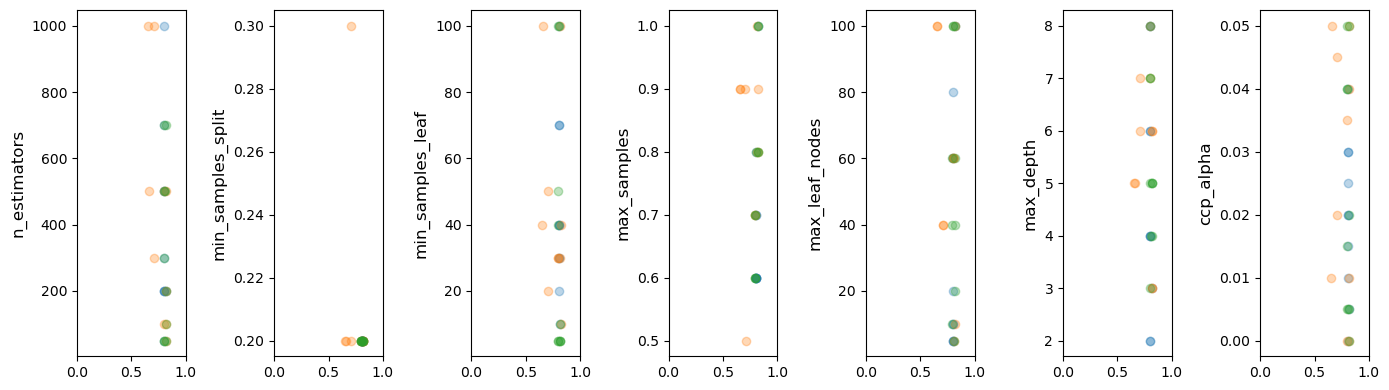

In [4]:
forest_model = models['forest']
forest_searches = forest_model['model_search']
list_forest_params = list(forest_searches[0][0].cv_results_['params'][0].keys())
list_forest_params.remove('max_features')
n_best = 10
forest_params = np.zeros((n_best, len(list_forest_params), 3))
forest_scores = np.zeros((n_best, 3))
permutes = []
best_forest_r2 = 0
best_forest_inds = [None, None]
cnt = 0
for i, shuff in enumerate(shuffle_types):
    for j, split in enumerate(split_types):
        # Skip the combination (Shuffled + Time Series)
        if i == 0 and j == 1:
            continue
        
        # Format the random search results
        permutes.append(f'{shuff} Data, {split}')
        rand_results = pd.DataFrame(forest_searches[i][j].cv_results_)
        rand_results = rand_results.sort_values(by=['rank_test_score'])
        rand_results = rand_results[['params', 'mean_test_score', 'std_test_score']]
        rank_inds = rand_results.index.values
        top10_R2_avg = rand_results.mean_test_score.iloc[:10].mean()
        if top10_R2_avg > best_forest_r2:
            best_forest_r2 = top10_R2_avg
            best_forest_inds = [i, j]
        # print(f'{shuff} data with {split}')
        # display(rand_results.head(n=10))
        
        # Distribute the parameters
        forest_scores[:, cnt] = rand_results.mean_test_score.iloc[:n_best]
        for n, ind in enumerate(rank_inds[:n_best]):
            for p, param in enumerate(list_forest_params):
                forest_params[n, p, cnt] = rand_results['params'][ind][param]
        cnt += 1
print(f'The most robust forest model is at the indices: {best_forest_inds}')

# Plot the results
fig, axes = plt.subplots(1, len(list_forest_params), figsize=(14, 4))
for p, param in enumerate(list_forest_params):
    for c, colour in enumerate(['C0', 'C1', 'C2']):
        axes[p].scatter(forest_scores[:, c], forest_params[:, p, c], c=colour, alpha=0.3)
        axes[p].set_ylabel(param, fontsize=12)
        axes[p].set_xlim([0, 1])
fig.tight_layout()

for i, c in enumerate(['Blue', 'Orange', 'Green']):
    print(f"The colour associated with {permutes[i]} is: {c}")


The most robust SVR model is at the indices: [0, 0]
The colour associated with Shuffled Data, Shuffle Split is: Blue
The colour associated with Contiguous Data, Shuffle Split is: Orange
The colour associated with Contiguous Data, Time Series Split is: Green


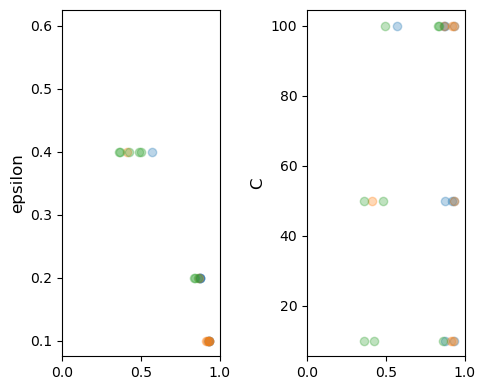

In [5]:
svr_model = models['svr']
svr_searches = svr_model['model_search_norm']
list_svr_params = list(svr_searches[0][0].cv_results_['params'][0].keys())
# print(list_svr_params)
list_svr_params.remove('gamma')
n_best = 10
svr_params = np.zeros((n_best, len(list_svr_params), 3))
svr_scores = np.zeros((n_best, 3))
best_svr_r2 = 0
best_svr_inds = [None, None]
cnt = 0
for i, shuff in enumerate(shuffle_types):
    for j, split in enumerate(split_types):
        # Skip the combination (Shuffled + Time Series)
        if i == 0 and j == 1:
            continue
        
        # Format the random search results
        rand_results = pd.DataFrame(svr_searches[i][j].cv_results_)
        rand_results = rand_results.sort_values(by=['rank_test_score'])
        rand_results = rand_results[['params', 'mean_test_score', 'std_test_score']]
        rank_inds = rand_results.index.values
        top10_R2_avg = rand_results.mean_test_score.iloc[:10].mean()
        if top10_R2_avg > best_svr_r2:
            best_svr_r2 = top10_R2_avg
            best_svr_inds = [i, j]
        # print(f'{shuff} data with {split}')
        # display(rand_results.head(n=10))
        
        # Distribute the parameters
        svr_scores[:, cnt] = rand_results.mean_test_score.iloc[:n_best]
        for n, ind in enumerate(rank_inds[:n_best]):
            for p, param in enumerate(list_svr_params):
                svr_params[n, p, cnt] = rand_results['params'][ind][param]
        cnt += 1
print(f'The most robust SVR model is at the indices: {best_svr_inds}')

# Plot the results
fig, axes = plt.subplots(1, len(list_svr_params), figsize=(5, 4))
for p, param in enumerate(list_svr_params):
    for c, color in enumerate(['C0', 'C1', 'C2']):
        axes[p].scatter(svr_scores[:, c], svr_params[:, p, c], c=color, alpha=0.3)
        axes[p].set_ylabel(param, fontsize=12)
        axes[p].set_xlim([0, 1])
fig.tight_layout()

for i, c in enumerate(['Blue', 'Orange', 'Green']):
    print(f"The colour associated with {permutes[i]} is: {c}")


['subsample', 'n_estimators', 'min_child_weight', 'max_leaves', 'max_depth', 'learning_rate', 'gamma']
The most robust XGBoost model is at the indices: [1, 0]
The colour associated with Shuffled, Shuffle Split is: Blue
The colour associated with Contiguous, Shuffle Split is: Orange
The colour associated with Contiguous, Time Series Split is: Green


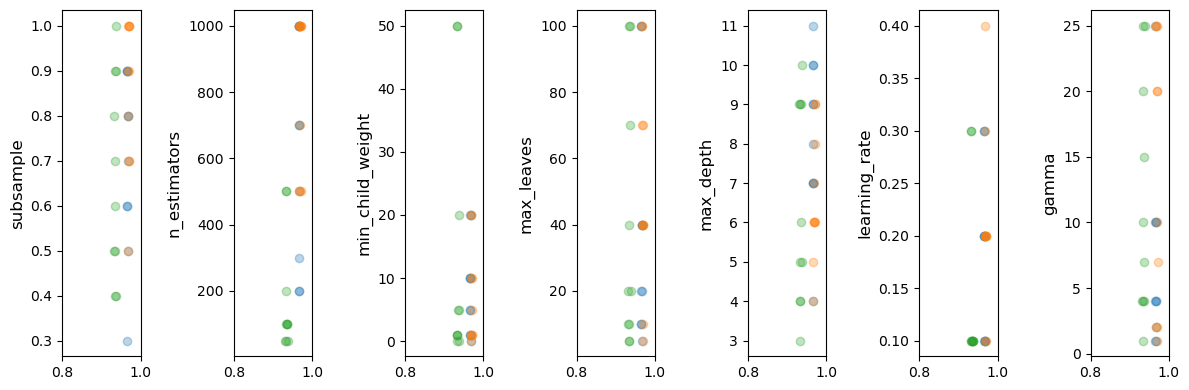

In [6]:
xgb_model = models['xgb']
xgb_searches = xgb_model['model_search']
list_xgb_params = list(xgb_searches[0][0].cv_results_['params'][0].keys())
print(list_xgb_params)
n_best = 10
xgb_params = np.zeros((n_best, len(list_xgb_params), 3))
xgb_scores = np.zeros((n_best, 3))
permutes = []
best_xgb_r2 = 0
best_xgb_inds = [None, None]
cnt = 0
for i, shuff in enumerate(shuffle_types):
    for j, split in enumerate(split_types):
        # Skip the combination (Shuffled + Time Series)
        if i == 0 and j == 1:
            continue
        
        # Format the random search results
        permutes.append(f'{shuff}, {split}')
        rand_results = pd.DataFrame(xgb_searches[i][j].cv_results_)
        rand_results = rand_results.sort_values(by=['rank_test_score'])
        rand_results = rand_results[['params', 'mean_test_score', 'std_test_score']]
        rank_inds = rand_results.index.values
        top10_R2_avg = rand_results.mean_test_score.iloc[:10].mean()
        if top10_R2_avg > best_xgb_r2:
            best_xgb_r2 = top10_R2_avg
            best_xgb_inds = [i, j]
        # print(f'{shuff} data with {split}')
        # display(rand_results.head(n=10))
        
        # Distribute the parameters
        xgb_scores[:, cnt] = rand_results.mean_test_score.iloc[:n_best]
        for n, ind in enumerate(rank_inds[:n_best]):
            for p, param in enumerate(list_xgb_params):
                xgb_params[n, p, cnt] = rand_results['params'][ind][param]
        cnt += 1
print(f'The most robust XGBoost model is at the indices: {best_xgb_inds}')

# Plot the results
fig, axes = plt.subplots(1, len(list_xgb_params), figsize=(12, 4))
for p, param in enumerate(list_xgb_params):
    for c, color in enumerate(['C0', 'C1', 'C2']):
        axes[p].scatter(xgb_scores[:, c], xgb_params[:, p, c], c=color, alpha=0.3)
        axes[p].set_ylabel(param, fontsize=12)
        axes[p].set_xlim([0.8, 1])
fig.tight_layout()

for i, c in enumerate(['Blue', 'Orange', 'Green']):
    print(f"The colour associated with {permutes[i]} is: {c}")


## Conclusions and Lessons Learned

Visualizing the randomized parameter search results shows how robust the model is to certain parameter selections. There are three identifiable patterns to the parameter distributions:

1. There is a relatively even distribution of parameter values, and a relatively constant $R^2$ score associated with all values. This indicates that the parameter does not have a strong effect on model performance. However, there is still usually a trend that indicates what range the parameter should lie in. 
2. The best parameter is the same across most models, as with the "min_samples_split" parameter in the random forest model. Nearly all of the best performing models used a value of 0.2, so it is clear what the optimal choice is.
3. There is a clear correlation between the parameter value and performance. The best example of this is epsilon in the SVR model, where smaller values lead to better training scores. 

However, it should be noted that these parameters are evaluated using cross-validation, so there may be some effects due to over fitting. Therefore, in cases where there is not a clear consensus in what value of the parameter is best, one should lean towards regularization.
